### 1. What are 3 areas in industry where computer vision is currently being used?

I. Defects detection on assembly line <br>
II. Self-driving vehicles <br>
III. Face recognition 

### 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting occurs when a machine learning model is trained on the training data repeatedly. Over time the model will perform very well on the training data, but poorly on the test data. 

### 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. Note: there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

I. Hold-out: Splitting the whole dataset to training and testing datasets. <br>
II. Data Augmentation: Creates new data from the available data. <br>
III. Regularization:  This makes the model learn broader patterns rather then memorizing the data.

### 4. Spend 20-minutes reading and clicking through the <a href="https://poloclub.github.io/cnn-explainer/"> CNN Explainer website </a>.
    * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.

### 5. Load the <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST">torchvision.datasets.MNIST()</a> train and test datasets.

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import randrange
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


/home/archian/Development/Projects/Python/Torch/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = datasets.MNIST(root='data',train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root='data',train=False,download=True,transform=ToTensor())

### 6. Visualize at least 5 different samples of the MNIST training dataset.

In [4]:
class_name =  train_data.classes

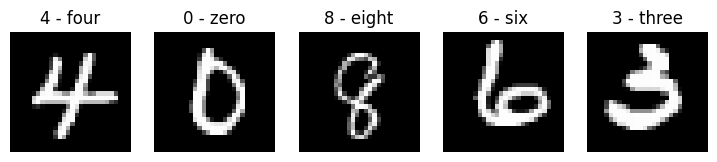

In [5]:
fig = plt.figure(figsize=(9,9))
row,colm = 1,5
for i in range(1,row*colm+1):
    random_index = torch.randint(1,len(train_data),size=[1]).item()
    image,label = train_data[random_index]
    fig.add_subplot(row,colm,i)
    plt.title(class_name[label])
    plt.axis(False)
    plt.imshow(image.squeeze(),cmap="gray")

### 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [6]:
train_dataloader =  DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=32)   

### 8. Recreate model_2 used in this notebook (the same model from the <a href='https://poloclub.github.io/cnn-explainer/'>CNN Explainer website</a>, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [7]:
class MNISTModel(nn.Module):
    def __init__(self,input_shape,output_shape,hidden_units):
        super().__init__()
        self.block_1= nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )
        
    def forward(self,x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.linear_layer(x)
        return x

### 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [8]:
model_0 = MNISTModel(input_shape=1,output_shape=len(class_name),hidden_units=10)
next(model_0.parameters()).device

device(type='cpu')

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [ ]:
%%time
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"---Epoch: {epoch}---")
    train_loss = 0
    for batch,(X,y) in enumerate(train_dataloader):
        model_0.train()
        # Forward Pass
        y_pred = model_0(X)
        # Calculate the loss
        loss = loss_fn(y_pred,y)
        train_loss += loss 
        # Optimizer zero grad
        optimizer.zero_grad()
        # loss backwards
        loss.backward()
        # Step the optimizer
        optimizer.step()


    train_loss /= len(train_dataloader)
    # Test the model
    test_loss = 0
    model_0.eval()
    with torch.inference_mode():
        for batch,(X_test,y_test) in enumerate(test_dataloader):
            test_pred = model_0(X_test)
            # Calculate the loss
            test_loss += loss_fn(test_pred,y_test) 
                

        test_loss /= len(test_dataloader)
    print(f"Loss: {train_loss:.3f} | Test loss: {test_loss:.3f}")
    

  0%|          | 0/3 [00:00<?, ?it/s]

---Epoch: 0---


 33%|███▎      | 1/3 [01:12<02:25, 72.83s/it]

Loss: 0.335 | Test loss: 0.096
---Epoch: 1---


In [11]:
# %%time


# # Model on GPU
# model_0_gpu = MNISTModel(input_shape=1,hidden_units=10,output_shape=10).to(device)


# # Training loop
# epochs = 3
# for epoch in tqdm(range(epochs)):
#   print(f"---Epoch: {epoch}---")
#   train_loss = 0
#   model_0_gpu.train()
#   for batch, (X, y) in enumerate(train_dataloader):
#     # Put data on target device
#     X, y = X.to(device), y.to(device)

#     # Forward pass
#     y_pred = model_0_gpu(X)

#     # Calculate the loss
#     loss = loss_fn(y_pred, y)
#     train_loss += loss

#     # Optimizer zero grad
#     optimizer.zero_grad()

#     # Loss backwards
#     loss.backward()

#     # Step the optimizer
#     optimizer.step()
  
#   train_loss /= len(train_dataloader)

#   # Test the modek
#   test_loss = 0
#   model_0_gpu.eval()
#   with torch.inference_mode():
#     for batch, (X_test, y_test) in enumerate(test_dataloader):
#       # Make sure test data on target device
#       X_test, y_test = X_test.to(device), y_test.to(device)
      
#       test_pred = model_0_gpu(X_test)
#       test_loss = loss_fn(test_pred, y_test)

#       test_loss += test_loss

#     # Adjust test loss total for number of batches
#     test_loss /= len(test_dataloader)
  
#   # Print out what's happening
#   print(f"Loss: {train_loss} | Test loss: {test_loss}")

  0%|          | 0/3 [00:00<?, ?it/s]

---Epoch: 0---


 33%|███▎      | 1/3 [00:23<00:47, 23.69s/it]

Loss: 2.3039469718933105 | Test loss: 0.014705562964081764
---Epoch: 1---


 67%|██████▋   | 2/3 [00:48<00:24, 24.39s/it]

Loss: 2.303945779800415 | Test loss: 0.014705562964081764
---Epoch: 2---


100%|██████████| 3/3 [01:13<00:00, 24.56s/it]

Loss: 2.3039488792419434 | Test loss: 0.014705562964081764
CPU times: user 1min 11s, sys: 845 ms, total: 1min 12s
Wall time: 1min 13s


### 10.Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

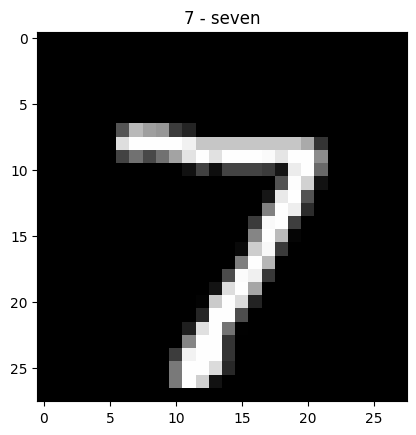

In [12]:
test_image, test_label = test_data[0]
plt.imshow(test_image.squeeze(),cmap="gray")
plt.title(class_name[test_label])
plt.show()

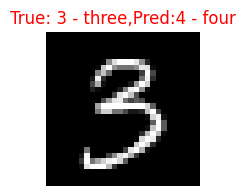

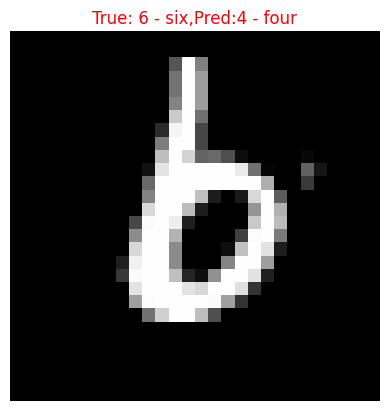

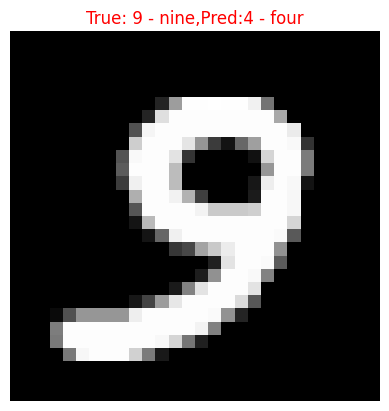

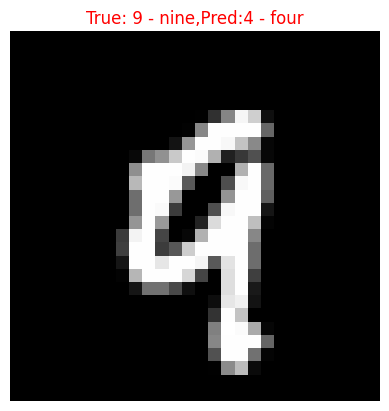

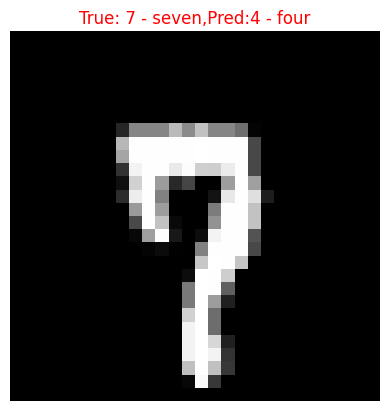

In [32]:
pred_fig = plt.figure(figsize=(2,2))
rows,colms = 1,5
for i in range(1,rows*colms+1):
    random_index = torch.randint(1,len(test_data),size=[1]).item()
    test_image, test_label = test_data[random_index]
    # test_image = test_image.to(device)
    y_logits = model_0(test_image.unsqueeze(0))
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    fig.add_subplot(rows,colms,i)
    if y_pred == test_label:
        plt.title(f"True: {class_name[test_label]},Pred:{class_name[y_pred]}", c="g")
    else:
        plt.title(f"True: {class_name[test_label]},Pred:{class_name[y_pred]}", c="r")
    plt.axis(False)
    plt.imshow(test_image.squeeze().to('cpu'),cmap="gray")
    plt.show()

### 11.Plot a confusion matrix comparing your model's predictions to the truth labels.

In [26]:
# Making a confusion matrix for further predictions

confmat = ConfusionMatrix(num_classes=len(class_name),task="MULTICLASS")
confmat_tensor = confmat(preds=y_pred,target=test_label)

# Plot the confusion matrix
# fig,ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),class_names=class_name,figsize=(10,7))


AttributeError: 'int' object has no attribute 'ndim'

### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

sample_tensor = torch.randint([1,3,64,64])
sample_tensor.shape